## Goal: Determine if population-specific exons have higher Fsts (mx. or mean) than shared

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import cerberus
import pyranges as pr
import upsetplot
import math


p = os.path.dirname(os.getcwd())
sys.path.append(p)

from scripts.utils import *
from scripts.vcf_utils import *
from scripts.plotting import *

In [2]:
config = load_config()
od = '../'

def proc_cfg(entry, od):
    entry = entry.replace('../../', '')
    entry = od+entry
    return entry

## Dist of Fsts for all SNPs in all contrasts that intersect w/ exons

In [36]:
df = pd.read_csv(proc_cfg(config['lr']['exons_pop_spec_ss_fsts_summary'], od),
                 sep='\t')

# set all <0 fsts --> 0 https://www.biostars.org/p/132253/
df.loc[df.fst<0, 'fst'] = 0

# since this is biallelic snp level, remove all exons that didnt intersect
print(len(df.index))
df = df.loc[df.End_b!=-1]
print(len(df.index))

3769828
2299334


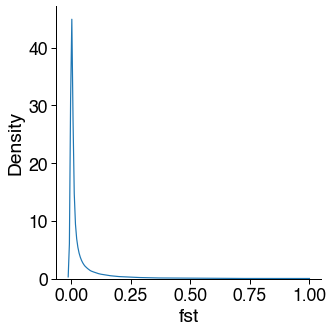

<Figure size 360x360 with 0 Axes>

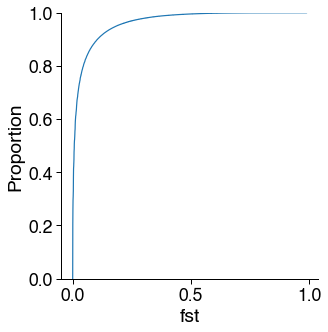

<Figure size 360x360 with 0 Axes>

In [37]:
init_plot_settings()
ax = sns.displot(df, 
            x='fst',
            kind='kde')
plt.show()
plt.clf()

# plot the Fst dists. for pop-spec and non-pop-spec
init_plot_settings()
ax = sns.displot(df, 
            x='fst',
            kind='ecdf') 
plt.show()
plt.clf()

## mean

In [49]:
df = pd.read_csv(proc_cfg(config['lr']['exons_pop_spec_ss_fsts_summary'], od),
                 sep='\t')

# set all <0 fsts --> 0 https://www.biostars.org/p/132253/
df.loc[df.fst<0, 'fst'] = 0

# since this is biallelic snp level, remove all exons that didnt intersect
print(len(df.index))
df = df.loc[df.End_b!=-1]
print(len(df.index))

3769828
2299334


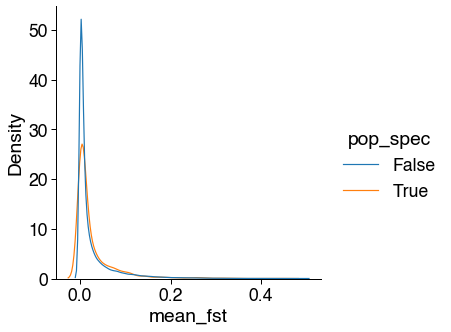

<Figure size 360x360 with 0 Axes>

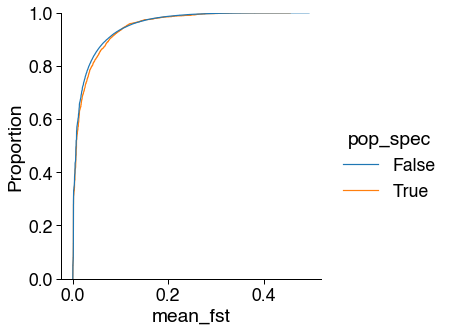

509530220.5
5.5556386459610246e-05


<Figure size 360x360 with 0 Axes>

In [50]:
# for each combination of exon and variant position, get the mean FST
# (which will be the mean between the contrasts)
gb_cols = ['eid', 'novelty', 'pop_spec', 'pop_spec_pop', # exon id stuff
           'End_b', 'Start_b'] # var. pos. stuff
keep_cols = gb_cols+['fst']
df = df[keep_cols].groupby(gb_cols).mean().reset_index().rename({'fst':'mean_fst'}, axis=1)

# make sure we have no dupe eid / var. pos. combos
assert len(df.index) == len(df[['eid', 'End_b', 'Start_b']].drop_duplicates().index)

# plot the Fst dists. for pop-spec and non-pop-spec
init_plot_settings()
ax = sns.displot(df, 
            x='mean_fst',
            hue='pop_spec',
            kind='kde',
            common_norm=False)  
plt.show()
plt.clf()

# plot the Fst dists. for pop-spec and non-pop-spec
init_plot_settings()
ax = sns.displot(df, 
            x='mean_fst',
            hue='pop_spec',
            kind='ecdf') 
plt.show()
plt.clf()

x = df.loc[df.pop_spec==True,'mean_fst'].tolist() # hyp. --> greater
y = df.loc[df.pop_spec==False,'mean_fst'].tolist()

# print(f'{pop1} vs {pop2}')
# print(temp.loc[temp.thing2=='unique','fst'].median())
# print(temp.loc[temp.thing2=='shared','fst'].median())
# print()

stat, pval = st.mannwhitneyu(x, y, alternative='greater')
print(stat)
print(pval)

## mean - mean

In [57]:
df = pd.read_csv(proc_cfg(config['lr']['exons_pop_spec_ss_fsts_summary'], od),
                 sep='\t')

# set all <0 fsts --> 0 https://www.biostars.org/p/132253/
df.loc[df.fst<0, 'fst'] = 0

# since this is biallelic snp level, remove all exons that didnt intersect
print(len(df.index))
df = df.loc[df.End_b!=-1]
print(len(df.index))

3769828
2299334


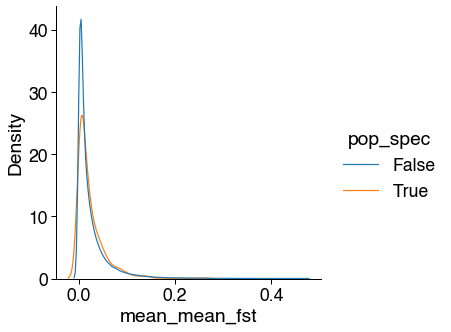

<Figure size 360x360 with 0 Axes>

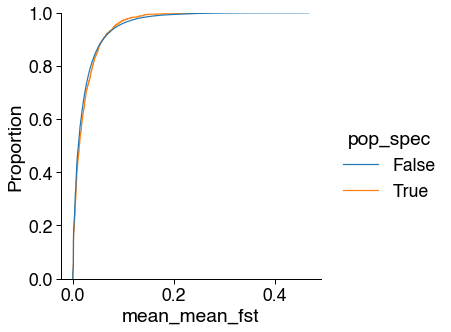

57320889.5
0.0027671343898767937


<Figure size 360x360 with 0 Axes>

In [58]:
# for each combination of exon and variant position, get the mean FST
# (which will be the mean between the contrasts)
gb_cols = ['eid', 'novelty', 'pop_spec', 'pop_spec_pop', # exon id stuff
           'End_b', 'Start_b'] # var. pos. stuff
keep_cols = gb_cols+['fst']
df = df[keep_cols].groupby(gb_cols).mean().reset_index().rename({'fst':'mean_fst'}, axis=1)

gb_cols = ['eid', 'novelty', 'pop_spec', 'pop_spec_pop'] # exon id stuff
keep_cols = gb_cols+['mean_fst']
df = df[keep_cols].groupby(gb_cols).mean().reset_index().rename({'mean_fst':'mean_mean_fst'}, axis=1)

# make sure we have no dupe eid / var. pos. combos
assert len(df.index) == len(df[['eid']].drop_duplicates().index)

# plot the Fst dists. for pop-spec and non-pop-spec
init_plot_settings()
ax = sns.displot(df, 
            x='mean_mean_fst',
            hue='pop_spec',
            kind='kde',
            common_norm=False)  
plt.show()
plt.clf()

# plot the Fst dists. for pop-spec and non-pop-spec
init_plot_settings()
ax = sns.displot(df, 
            x='mean_mean_fst',
            hue='pop_spec',
            kind='ecdf') 
plt.show()
plt.clf()

x = df.loc[df.pop_spec==True,'mean_mean_fst'].tolist() # hyp. --> greater
y = df.loc[df.pop_spec==False,'mean_mean_fst'].tolist()

# print(f'{pop1} vs {pop2}')
# print(temp.loc[temp.thing2=='unique','fst'].median())
# print(temp.loc[temp.thing2=='shared','fst'].median())
# print()

stat, pval = st.mannwhitneyu(x, y, alternative='greater')
print(stat)
print(pval)

In [60]:
df[['pop_spec', 'eid']].groupby('pop_spec').nunique()

,eid
pop_spec,
False,100918
True,1083


## a=amx

In [34]:
df = pd.read_csv(proc_cfg(config['lr']['exons_pop_spec_ss_fsts_summary'], od),
                 sep='\t')

# set all <0 fsts --> 0 https://www.biostars.org/p/132253/
df.loc[df.fst<0, 'fst'] = 0

# since this is biallelic snp level, remove all exons that didnt intersect
print(len(df.index))
df = df.loc[df.End_b!=-1]
print(len(df.index))

3769828
2299334


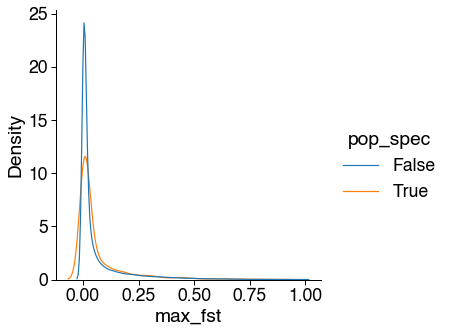

<Figure size 360x360 with 0 Axes>

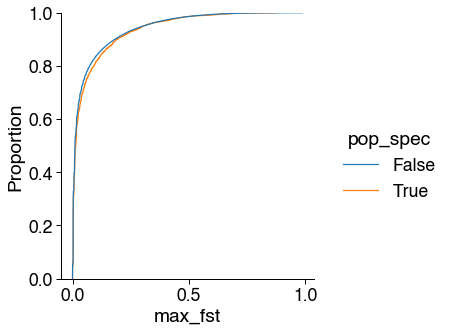

511282645.0
1.180408754154848e-05


<Figure size 360x360 with 0 Axes>

In [35]:
# for each combination of exon and variant position, get the mean FST
# (which will be the mean between the contrasts)
gb_cols = ['eid', 'novelty', 'pop_spec', 'pop_spec_pop', # exon id stuff
           'End_b', 'Start_b'] # var. pos. stuff
keep_cols = gb_cols+['fst']
df = df[keep_cols].groupby(gb_cols).max().reset_index().rename({'fst':'max_fst'}, axis=1)

# make sure we have no dupe eid / var. pos. combos
assert len(df.index) == len(df[['eid', 'End_b', 'Start_b']].drop_duplicates().index)

# plot the Fst dists. for pop-spec and non-pop-spec
init_plot_settings()
ax = sns.displot(df, 
            x='max_fst',
            hue='pop_spec',
            kind='kde',
            common_norm=False)  
plt.show()
plt.clf()

# plot the Fst dists. for pop-spec and non-pop-spec
init_plot_settings()
ax = sns.displot(df, 
            x='max_fst',
            hue='pop_spec',
            kind='ecdf') 
plt.show()
plt.clf()

x = df.loc[df.pop_spec==True,'max_fst'].tolist() # hyp. --> greater
y = df.loc[df.pop_spec==False,'max_fst'].tolist()

# print(f'{pop1} vs {pop2}')
# print(temp.loc[temp.thing2=='unique','fst'].median())
# print(temp.loc[temp.thing2=='shared','fst'].median())
# print()

stat, pval = st.mannwhitneyu(x, y, alternative='greater')
print(stat)
print(pval)

## What are standard deviations of SNPs w/i the same exon?

In [43]:
df = pd.read_csv(proc_cfg(config['lr']['exons_pop_spec_ss_fsts_summary'], od),
                 sep='\t')

# set all <0 fsts --> 0 https://www.biostars.org/p/132253/
df.loc[df.fst<0, 'fst'] = 0

# since this is biallelic snp level, remove all exons that didnt intersect
print(len(df.index))
df = df.loc[df.End_b!=-1]
print(len(df.index))

3769828
2299334


In [ ]:
df.head()

,Chromosome,Strand,Start,End,novelty,eid,pop_spec,pop_spec_pop,End_b,fst,Start_b,pop1,pop2
269,chr1,+,100007031,100007158,Known,chr1_+_100007033_100007156,False,YRI,100007048,0.393014,100007047,HAC,YRI
270,chr1,+,100043070,100043231,Known,chr1_+_100043072_100043229,False,HAC,100043099,0.041198,100043098,HAC,YRI
271,chr1,+,100043070,100043231,Known,chr1_+_100043072_100043229,False,HAC,100043213,0.000000,100043212,HAC,YRI
272,chr1,+,100049906,100050006,Known,chr1_+_100049908_100050004,False,PEL,100049941,0.018298,100049940,HAC,YRI
273,chr1,+,100140405,100141021,Known,chr1_+_100140407_100141019,False,HAC,100140797,0.047965,100140796,HAC,YRI


In [45]:
# for each combination of exon, get the std FST of SNPs in the 
# exon, across the contrasts
gb_cols = ['eid', 'novelty'] # exon id stuff
keep_cols = gb_cols+['fst']
df = df[keep_cols].groupby(gb_cols).std().reset_index().rename({'fst':'std_fst'}, axis=1)

# make sure we have no dupe eid / var. pos. combos
assert len(df.index) == len(df[['eid']].drop_duplicates().index)

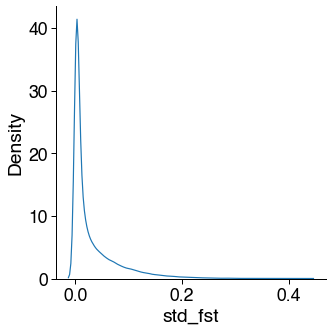

<Figure size 360x360 with 0 Axes>

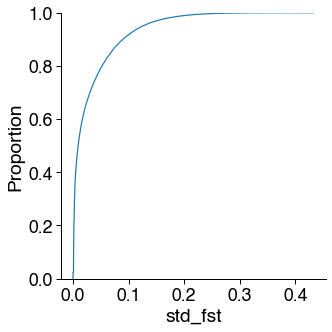

<Figure size 360x360 with 0 Axes>

In [46]:
init_plot_settings()
ax = sns.displot(df, 
            x='std_fst',
            kind='kde')  
plt.show()
plt.clf()

# plot the Fst dists. for pop-spec and non-pop-spec
init_plot_settings()
ax = sns.displot(df, 
            x='std_fst',
            kind='ecdf') 
plt.show()
plt.clf()

In [41]:
df.head()

,eid,novelty,pop_spec,pop_spec_pop,std_fst
0,chr10_+_1000676_1000868,Known,False,PEL,0.043283
1,chr10_+_1000947_1001013,Known,False,PEL,0.003493
2,chr10_+_100231245_100231660,Known,False,YRI,0.037649
3,chr10_+_100233230_100233443,Known,False,ITU,0.030017
4,chr10_+_100266373_100266499,Known,False,ITU,0.001990


In [42]:
df.std_fst.median()

0.009177646793828912